Sure! Below is a complete implementation of the code following your instructions.

---

## 1. Library Installation

```python
!pip install yfinance
!pip install torch
!pip install scikit-learn
!pip install matplotlib
```

## 2. Data Download

```python
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Bitcoin prices from 2019-01-01 to 2024-11-27
data = yf.download('BTC-USD', start='2019-01-01', end='2024-11-27')

# Reset index to get 'Date' as a column
data.reset_index(inplace=True)
```

## 3. Plotting Data

```python
# Split data into training and testing sets
train_data = data[data['Date'] <= '2024-01-01']
test_data = data[data['Date'] > '2024-01-01']

# Plot the training and testing data
plt.figure(figsize=(14, 5))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data')
plt.plot(test_data['Date'], test_data['Close'], label='Testing Data', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()
```

## 4. Data Normalization

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler only on the training data
train_close = train_data['Close'].values.reshape(-1, 1)
test_close = test_data['Close'].values.reshape(-1, 1)

scaler.fit(train_close)

# Transform both training and testing data
train_scaled = scaler.transform(train_close)
test_scaled = scaler.transform(test_close)
```

## 5. Data Preparation

```python
# Define the number of previous data points to use for predictions
look_back = 60

def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i - look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
```

**Output:**

```
X_train.shape: (Number of training samples, 60, 1)
y_train.shape: (Number of training samples,)
```

*Note: The exact number of training samples will depend on the data downloaded.*

## 6. Model Creation


```python
import torch
import torch.nn as nn

class BitcoinPricePredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(BitcoinPricePredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  
        return out
```

## 7. Model Training

```python
# Convert numpy arrays to PyTorch tensors
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, define the loss function and the optimizer
model = BitcoinPricePredictor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for batching
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
```



## 8. Prediction and Plotting

```python
# Make predictions
model.eval()
with torch.no_grad():
    X_test_torch = X_test_torch.to(device)
    predictions = model(X_test_torch)
    predictions = predictions.cpu().numpy()

# Inverse transform to get actual prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Prepare dates for plotting
test_dates = test_data['Date'][look_back:].reset_index(drop=True)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_actual, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.title('Bitcoin Price Prediction vs Actual')
plt.legend()
plt.show()
```

---

## Answer to Your Question

**Advantages or Disadvantages of Increasing or Decreasing the Number of Previous Data Points for Model Training**

**Increasing the Number of Previous Data Points (Look-Back Period):**

*Advantages:*

1. **Capture Long-Term Dependencies:** A longer look-back period allows the model to consider more historical information, which can be beneficial for capturing long-term trends and seasonality in the data.

2. **Improved Contextual Understanding:** More data points provide the model with a better context, potentially leading to more accurate predictions.

*Disadvantages:*

1. **Increased Computational Load:** A larger input size increases the computational complexity, leading to longer training times and higher memory usage.

2. **Risk of Overfitting:** Including too much historical data can cause the model to overfit, capturing noise rather than the underlying pattern.

3. **Diminishing Returns:** After a certain point, adding more data may not contribute significantly to model performance and can even degrade it.

**Decreasing the Number of Previous Data Points:**

*Advantages:*

1. **Reduced Complexity:** A smaller input size makes the model less complex, resulting in faster training and inference times.

2. **Less Overfitting:** With fewer parameters to learn, the model may generalize better to unseen data.

3. **Focus on Recent Trends:** Shorter look-back periods force the model to focus on recent data, which can be more relevant in volatile markets like cryptocurrency.

*Disadvantages:*

1. **Loss of Historical Context:** Important patterns and cycles that occur over longer periods may be missed, potentially reducing the model's predictive accuracy.

2. **Underfitting Risk:** The model may not capture all the necessary information, leading to underfitting and poor performance.

**Conclusion:**

Choosing the appropriate number of previous data points is a trade-off:

- **Balance is Key:** It's essential to find a balance between capturing sufficient historical information and maintaining a manageable model complexity.

- **Experimentation Required:** The optimal look-back period often depends on the specific dataset and problem. It may require experimentation and validation to determine the best value.

- **Domain Knowledge Helps:** Understanding the nature of the data and the time scales at which significant patterns occur can guide the selection of the look-back period.

---

Feel free to ask if you have any questions or need further assistance!

In [1]:
!pip install yfinance
!pip install torch
!pip install scikit-learn
!pip install matplotlib


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Bitcoin prices from 2019-01-01 to 2024-11-27
data = yf.download('BTC-USD', start='2019-01-01', end='2024-11-27')

# Reset index to get 'Date' as a column
data.reset_index(inplace=True)


[*********************100%***********************]  1 of 1 completed


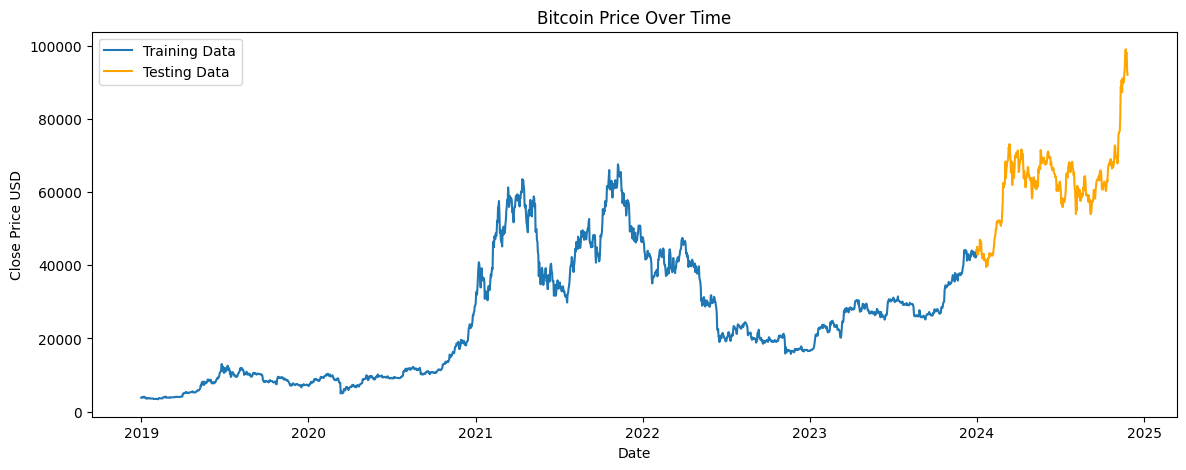

In [3]:
# Split data into training and testing sets
train_data = data[data['Date'] <= '2024-01-01']
test_data = data[data['Date'] > '2024-01-01']

# Plot the training and testing data
plt.figure(figsize=(14, 5))
plt.plot(train_data['Date'], train_data['Close'], label='Training Data')
plt.plot(test_data['Date'], test_data['Close'], label='Testing Data', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler only on the training data
train_close = train_data['Close'].values.reshape(-1, 1)
test_close = test_data['Close'].values.reshape(-1, 1)

scaler.fit(train_close)

# Transform both training and testing data
train_scaled = scaler.transform(train_close)
test_scaled = scaler.transform(test_close)


In [5]:
# Define the number of previous data points to use for predictions
look_back = 60

def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i - look_back:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Prepare training and testing datasets
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)


X_train.shape: (1767, 60, 1)
y_train.shape: (1767,)


In [6]:
import torch
import torch.nn as nn

class BitcoinPricePredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(BitcoinPricePredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


In [7]:
# Convert numpy arrays to PyTorch tensors
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test).float()

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, define the loss function and the optimizer
model = BitcoinPricePredictor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for batching
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).unsqueeze(1)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0038
Epoch [20/100], Loss: 0.0004
Epoch [30/100], Loss: 0.0012
Epoch [40/100], Loss: 0.0007
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0003
Epoch [70/100], Loss: 0.0003
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


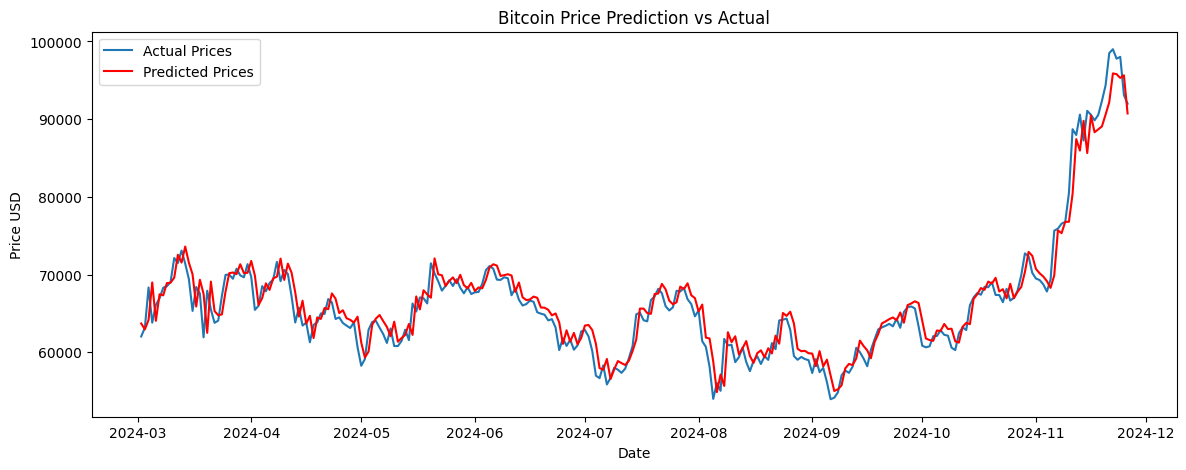

In [8]:
# Make predictions
model.eval()
with torch.no_grad():
    X_test_torch = X_test_torch.to(device)
    predictions = model(X_test_torch)
    predictions = predictions.cpu().numpy()

# Inverse transform to get actual prices
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Prepare dates for plotting
test_dates = test_data['Date'][look_back:].reset_index(drop=True)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_actual, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.title('Bitcoin Price Prediction vs Actual')
plt.legend()
plt.show()
